## Imports

In [1]:
import numpy as np
import tensorflow as tf
from os import listdir
import matplotlib.pyplot as plt
import cv2 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from keras.backend.tensorflow_backend import set_session
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

Using TensorFlow backend.


In [2]:
# The proof is in the pudding... Checking if TF is running on my GPU or CPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5523962154048887789
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6696213545
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2205909154009514757
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:
# This code solution from https://github.com/keras-team/keras/issues/4161 -- it will allow my GPU to dynamically
# grow its memory and not crash when fitting my models.
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

## Functions

In [4]:
# This code inspired by muliple different CV2 uses on Stackoverflow and Kaggle
image_size = tuple((128, 128)) #Specify what size you want your images to be here
# The following function will convert all my images to arrays
def arrayify(image_directory):
    try:
        image = cv2.imread(image_directory) # This will read in an image from the image directory
        if image is not None: #If the image exists, do the following:
            image = cv2.resize(image, image_size) # Resize the image to whatever image_size is defined as
            return img_to_array(image)
        else:
            return np.array([]) #Else... return an empty array (doing this mostly to prevent NaNs
                                # and other forms of data implosion)
    except Exception: #If there is an error...
        print (f"Nope!! {Exception}") #Let me know
        return None 

In [5]:
# This code inspired by multiple different instances and examples of image preprocessing on
# Stackoverflow, Kaggle, and from General Assembly lesson examples
def process_images(image_directory): 
    #Let's instantiate some lists!
    image_list = []
    label_list = []
    try:
        print("Loading Images ༼ つ ◕_◕ ༽つ")
        actual_folder = listdir(image_directory) # listdir will give me the directory for every folder
            # in the given directory, I can then use these directories in my function
        for folder in actual_folder:  
            if folder == ".DS_Store": #I don't want .DS_Store to be called for this function
                actual_folder.remove(folder)
        for image_folder in actual_folder: # For each specific image folder in the main folder...
            print(f"Processing {image_folder}...")
            formatted_image_list = listdir(f"{image_directory}/{image_folder}/") #Pull the images out and put them in a list
            for image in formatted_image_list: #For each image in the image list
                if image == ".DS_Store":
                    formatted_image_list.remove(image)
            for image in formatted_image_list:
                specific_image = f"{image_directory}/{image_folder}/{image}" #Create a specific image
                # Variable
                if specific_image.lower().endswith(".jpg") == True: #So long as the directory ends with
                    # .jpg, do the following
                    resized_array = arrayify(specific_image) # call the arrayify function on the image
                    image_list.append(resized_array) # append the resized array to the image_list var
                    label_list.append(image_folder) # Add the folder that the image came from as its "label"
        print("Processing Complete")
        return image_list, label_list
                    
                
                
                
                    
    except: #If there is an error...
        print (f"Nope!! {Exception}") #Let me know
        return None 

## Processing Image Directories

In [6]:
plant_village_arrays, plant_village_labels = process_images("./Images/PlantVillage")

Loading Images ༼ つ ◕_◕ ༽つ
Processing Pepper__bell___Bacterial_spot...
Processing Pepper__bell___healthy...
Processing Potato___Early_blight...
Processing Potato___healthy...
Processing Potato___Late_blight...
Processing Tomato_Bacterial_spot...
Processing Tomato_Early_blight...
Processing Tomato_healthy...
Processing Tomato_Late_blight...
Processing Tomato_Leaf_Mold...
Processing Tomato_Septoria_leaf_spot...
Processing Tomato_Spider_mites_Two_spotted_spider_mite...
Processing Tomato__Target_Spot...
Processing Tomato__Tomato_mosaic_virus...
Processing Tomato__Tomato_YellowLeaf__Curl_Virus...
Processing Complete


In [7]:
print(f"Processed {len(plant_village_arrays)} Images from the Plantvillage Dataset, Size {image_size}")
print(f"Labels for the Plantvillage Dataset are as follows: \n {set(plant_village_labels)}")

Processed 20636 Images from the Plantvillage Dataset, Size (128, 128)
Labels for the Plantvillage Dataset are as follows: 
 {'Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Tomato_Leaf_Mold', 'Tomato__Target_Spot', 'Tomato_Septoria_leaf_spot', 'Tomato_Late_blight', 'Potato___Early_blight', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Potato___healthy', 'Tomato__Tomato_mosaic_virus', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Bacterial_spot', 'Potato___Late_blight', 'Tomato_healthy', 'Tomato_Early_blight'}


In [8]:
rice_arrays, rice_labels = process_images('./Images/Rice')

Loading Images ༼ つ ◕_◕ ༽つ
Processing rice_Brown_Spot...
Processing rice_Healthy...
Processing rice_Hispa...
Processing rice_Leaf_Blast...
Processing Complete


In [9]:
print(f"Processed {len(rice_arrays)} Images from the Rice Dataset, Size {image_size}")
print(f"Labels for the Rice Dataset are as follows: \n {set(rice_labels)}")

Processed 3355 Images from the Rice Dataset, Size (128, 128)
Labels for the Rice Dataset are as follows: 
 {'rice_Hispa', 'rice_Brown_Spot', 'rice_Leaf_Blast', 'rice_Healthy'}


In [10]:
# Transforming my Labels into numbers using LabelBinarizer

lb = LabelBinarizer()
lb_plant_village_labels = lb.fit_transform(plant_village_labels)
lb_rice_labels = lb.fit_transform(rice_labels)

## Initial Multiclass CNN with Plantvillage dataset

In [11]:
# Defining X and y vars
X = plant_village_arrays
y = lb_plant_village_labels

In [12]:
# Train test split!
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state =42)


In [13]:
# Converting X_train and X_test into float arrays so they can be normalized
X_train = np.array(X_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)

In [14]:
# Normalizing X_train and X_test
X_train /= 255
X_test /= 255

In [15]:
# Transformed Image Size is what determines these variables 
width = 128
height = 128
depth = 3


In [16]:
# Model Instantiation
plant_vil_model = Sequential()

# Input
plant_vil_model.add(Conv2D(32, (3,3), input_shape = (width, height, depth)))
plant_vil_model.add(Activation("relu"))
plant_vil_model.add(MaxPooling2D(pool_size=(3,3)))
plant_vil_model.add(Dropout(0.25))

# Second Layer
plant_vil_model.add(Conv2D(64, (3,3)))
plant_vil_model.add(Activation("relu"))
plant_vil_model.add(Dropout(0.25))

# Third Layer
plant_vil_model.add(Conv2D(128, (3,3)))
plant_vil_model.add(Activation("relu"))
plant_vil_model.add(MaxPooling2D(pool_size=(2,2)))
plant_vil_model.add(Dropout(0.25))

# Flatten It
plant_vil_model.add(Flatten())

# Fourth Layer 
plant_vil_model.add(Dense(128))
plant_vil_model.add(Activation("relu"))

#Fifth Layer
plant_vil_model.add(Dense(64))
plant_vil_model.add(Activation("relu"))

# Final Output Layer
plant_vil_model.add(Dense(15))
plant_vil_model.add(Activation("softmax"))


# Compile the Model
plant_vil_model.compile(loss='categorical_crossentropy',
                       optimizer='adam',
                       metrics=['accuracy'])



W0826 17:31:20.353652 28776 deprecation_wrapper.py:119] From C:\Users\JoeRo\Anaconda3\envs\keras_gpu\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0826 17:31:20.355636 28776 deprecation_wrapper.py:119] From C:\Users\JoeRo\Anaconda3\envs\keras_gpu\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0826 17:31:20.417235 28776 deprecation_wrapper.py:119] From C:\Users\JoeRo\Anaconda3\envs\keras_gpu\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0826 17:31:20.467104 28776 deprecation_wrapper.py:119] From C:\Users\JoeRo\Anaconda3\envs\keras_gpu\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0826 17:31:20.4690

In [17]:
plant_vil_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 42, 42, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 42, 42, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 40, 40, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 40, 40, 64)        0         
__________

In [18]:
history2 = plant_vil_model.fit(X_train, y_train, 
                               batch_size=32, 
                               validation_data=(X_test, y_test), 
                               epochs=25, 
                               verbose=1)

W0826 17:31:20.842138 28776 deprecation.py:323] From C:\Users\JoeRo\Anaconda3\envs\keras_gpu\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 16508 samples, validate on 4128 samples
Epoch 1/25
16508/16508 [==============================] - 33s 2ms/step - loss: 1.5167 - acc: 0.5096 - val_loss: 0.8796 - val_acc: 0.7074
Epoch 2/25
16508/16508 [==============================] - 17s 1ms/step - loss: 0.6076 - acc: 0.7955 - val_loss: 0.6035 - val_acc: 0.8035
Epoch 3/25
16508/16508 [==============================] - 17s 1ms/step - loss: 0.4127 - acc: 0.8596 - val_loss: 0.3898 - val_acc: 0.8755
Epoch 4/25
16508/16508 [==============================] - 17s 1ms/step - loss: 0.3114 - acc: 0.8943 - val_loss: 0.3875 - val_acc: 0.8704
Epoch 5/25
16508/16508 [==============================] - 17s 1ms/step - loss: 0.2460 - acc: 0.9183 - val_loss: 0.3559 - val_acc: 0.8876
Epoch 6/25
16508/16508 [==============================] - 17s 1ms/step - loss: 0.1898 - acc: 0.9376 - val_loss: 0.3061 - val_acc: 0.9041
Epoch 7/25
16508/16508 [==============================] - 17s 1ms/step - loss: 0.1669 - acc: 0.9449 - val_loss: 0.4473 - val_acc:

## Initial Multiclass CNN with Rice dataset

In [19]:
# Defining X and y vars
X = rice_arrays
y = lb_rice_labels

In [20]:
# Train test split!
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state =42)

In [21]:
# Converting X_train and X_test into float arrays so they can be normalized
X_train = np.array(X_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)

In [22]:
# Normalizing X_train and X_test
X_train /= 255
X_test /= 255

In [23]:
# Model Instantiation
rice_model = Sequential()

# Input
rice_model.add(Conv2D(32, (3,3), input_shape = (width, height, depth)))
rice_model.add(Activation("relu"))
rice_model.add(MaxPooling2D(pool_size=(3,3)))
rice_model.add(Dropout(0.25))

# Second Layer
rice_model.add(Conv2D(64, (3,3)))
rice_model.add(Activation("relu"))
rice_model.add(Dropout(0.25))

# Third Layer
rice_model.add(Conv2D(128, (3,3)))
rice_model.add(Activation("relu"))
rice_model.add(MaxPooling2D(pool_size=(2,2)))
rice_model.add(Dropout(0.25))

# Flatten It
rice_model.add(Flatten())

# Fourth Layer 
rice_model.add(Dense(128))
rice_model.add(Activation("relu"))

#Fifth Layer
rice_model.add(Dense(64))
rice_model.add(Activation("relu"))

# Final Output Layer
rice_model.add(Dense(4))
rice_model.add(Activation("softmax"))


# Compile the Model
rice_model.compile(loss='categorical_crossentropy',
                       optimizer='adam',
                       metrics=['accuracy'])



In [24]:
rice_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
activation_7 (Activation)    (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 42, 42, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 42, 42, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 40, 40, 64)        18496     
_________________________________________________________________
activation_8 (Activation)    (None, 40, 40, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 40, 40, 64)        0         
__________

In [25]:
history1 = rice_model.fit(X_train, y_train, batch_size=32, validation_data=(X_test, y_test), epochs=25, verbose=1)

Train on 2684 samples, validate on 671 samples
Epoch 1/25
2684/2684 [==============================] - 22s 8ms/step - loss: 1.3658 - acc: 0.4266 - val_loss: 1.2893 - val_acc: 0.4545
Epoch 2/25
2684/2684 [==============================] - 3s 1ms/step - loss: 1.2370 - acc: 0.4579 - val_loss: 1.1880 - val_acc: 0.4844
Epoch 3/25
2684/2684 [==============================] - 3s 1ms/step - loss: 1.1477 - acc: 0.5030 - val_loss: 1.1407 - val_acc: 0.5216
Epoch 4/25
2684/2684 [==============================] - 3s 1ms/step - loss: 1.1064 - acc: 0.5216 - val_loss: 1.1398 - val_acc: 0.5440
Epoch 5/25
2684/2684 [==============================] - 3s 1ms/step - loss: 1.0815 - acc: 0.5235 - val_loss: 1.0839 - val_acc: 0.5514
Epoch 6/25
2684/2684 [==============================] - 3s 1ms/step - loss: 1.0411 - acc: 0.5432 - val_loss: 1.0852 - val_acc: 0.5768
Epoch 7/25
2684/2684 [==============================] - 3s 1ms/step - loss: 1.0157 - acc: 0.5540 - val_loss: 1.0967 - val_acc: 0.5276
Epoch 8/25
268

# Initial Thoughts
- So my initial accuracy scores indicate that my plant-village images are trainng pretty well, with a validation accuracy of about 90%. My Rice images are not doing well, though. I suspect this is because of the image size of 128x128. Sadly there isn't much I can do about this because of the limitations of my computer. Let's try combining arrays and labels to see how the NN performs with the rice added alongside the other plantvillage crops. I suspect this will negatively impact score.

## Multiclass CNN with combined image datasets

In [26]:
# Combining my Arrays and Labels
combined_arrays = plant_village_arrays + rice_arrays
combined_labels = plant_village_labels + rice_labels

In [27]:
# Binarizing my labels
lb_combined_labels = lb.fit_transform(combined_labels)

In [28]:
# Defining my X and y vars
X = combined_arrays
y = lb_combined_labels

In [29]:
# Train test split!
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state =42)

In [30]:
# Converting X_train and X_test into float arrays so they can be normalized
X_train = np.array(X_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)

In [31]:
# Model Instantiation
model = Sequential()

# Input
model.add(Conv2D(32, (3,3), input_shape = (width, height, depth)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Dropout(0.25))

# Second Layer
model.add(Conv2D(64, (3,3)))
model.add(Activation("relu"))
model.add(Dropout(0.25))

# Third Layer
model.add(Conv2D(128, (3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Flatten It
model.add(Flatten())

# Fourth Layer 
model.add(Dense(128))
model.add(Activation("relu"))

#Fifth Layer
model.add(Dense(64))
model.add(Activation("relu"))

# Final Output Layer
model.add(Dense(19))
model.add(Activation("softmax"))


# Compile the Model
model.compile(loss='categorical_crossentropy',
                       optimizer='adam',
                       metrics=['accuracy'])


In [32]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
activation_13 (Activation)   (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 42, 42, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 42, 42, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 40, 40, 64)        18496     
_________________________________________________________________
activation_14 (Activation)   (None, 40, 40, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 40, 40, 64)        0         
__________

In [33]:
history3 = model.fit(X_train, y_train, batch_size=32, validation_data=(X_test, y_test), epochs=25, verbose=1)

Train on 19192 samples, validate on 4799 samples
Epoch 1/25
19192/19192 [==============================] - 48s 3ms/step - loss: 14.8197 - acc: 0.0806 - val_loss: 14.9056 - val_acc: 0.0752
Epoch 2/25
19192/19192 [==============================] - 20s 1ms/step - loss: 14.8189 - acc: 0.0806 - val_loss: 14.9056 - val_acc: 0.0752
Epoch 3/25
19192/19192 [==============================] - 20s 1ms/step - loss: 14.8189 - acc: 0.0806 - val_loss: 14.9056 - val_acc: 0.0752
Epoch 4/25
19192/19192 [==============================] - 20s 1ms/step - loss: 14.8189 - acc: 0.0806 - val_loss: 14.9056 - val_acc: 0.0752
Epoch 5/25
19192/19192 [==============================] - 20s 1ms/step - loss: 14.8189 - acc: 0.0806 - val_loss: 14.9056 - val_acc: 0.0752
Epoch 6/25
19192/19192 [==============================] - 20s 1ms/step - loss: 14.8189 - acc: 0.0806 - val_loss: 14.9056 - val_acc: 0.0752
Epoch 7/25
19192/19192 [==============================] - 20s 1ms/step - loss: 14.8189 - acc: 0.0806 - val_loss: 14.9

In [34]:
scores = model.evaluate(X_test, y_test)
print(f"Model Accuracy: {scores[1]*100}")

4799/4799 [==============================] - 2s 355us/step
Model Accuracy: 7.522400498862167


## Analysis
- This score ended up a lot better then I expected. 85% Isn't too shabby considering the validation accuracy of the rice array by itself. Makes me really think that if I could just scale these images up in size I could see better results.

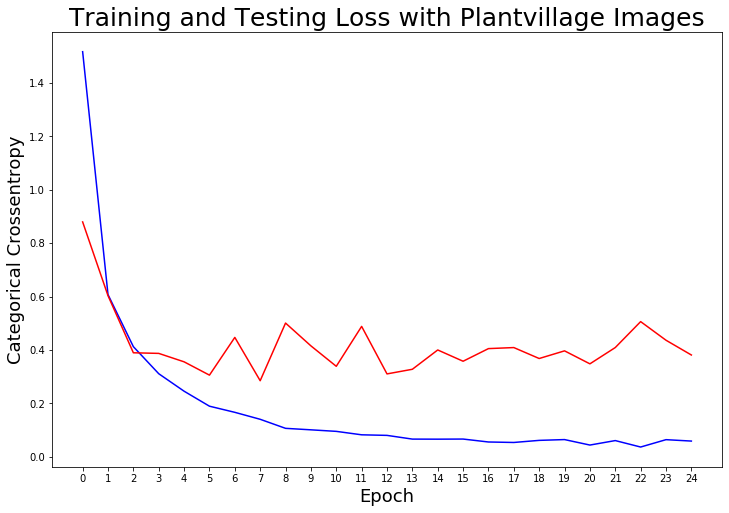

In [35]:
# Check out our train loss and test loss over epochs.
train_loss = history2.history['loss']
test_loss = history2.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='b')
plt.plot(test_loss, label='Testing Loss', color='r')

# Set title
plt.title('Training and Testing Loss with Plantvillage Images', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(25));

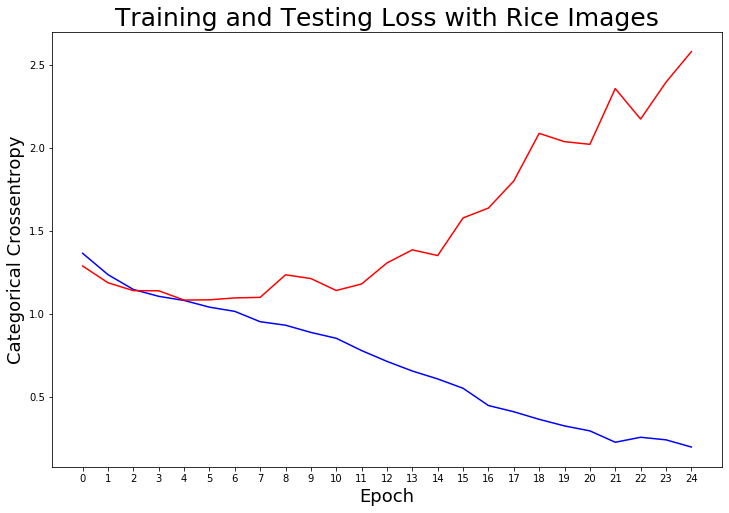

In [36]:
# Check out our train loss and test loss over epochs.
train_loss = history1.history['loss']
test_loss = history1.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='b')
plt.plot(test_loss, label='Testing Loss', color='r')

# Set title
plt.title('Training and Testing Loss with Rice Images', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(25));

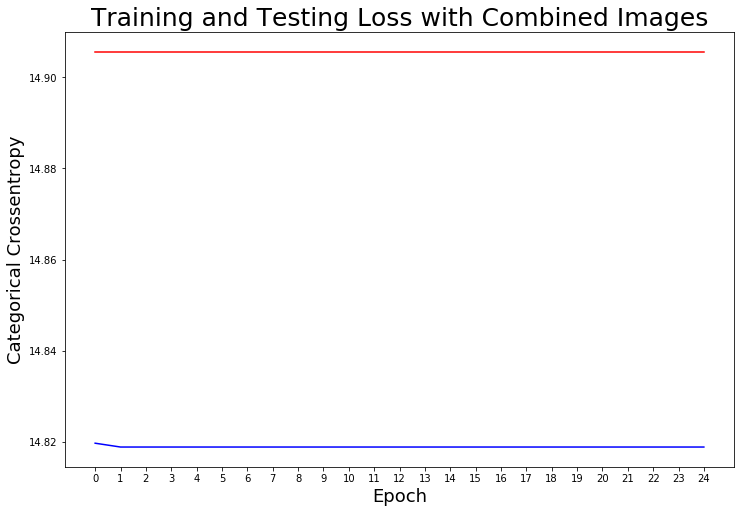

In [37]:
# Check out our train loss and test loss over epochs.
train_loss = history3.history['loss']
test_loss = history3.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='b')
plt.plot(test_loss, label='Testing Loss', color='r')

# Set title
plt.title('Training and Testing Loss with Combined Images', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(25));